In [1]:
from __future__ import print_function

import os
import subprocess
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import tarfile
from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange
import time


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
cifar-10-batches-py


In [7]:
# Load dataset
data_path = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

local_data_dir = "/content/drive/My Drive/data"
tf.gfile.MakeDirs(local_data_dir)

url = urllib.request.urlopen(data_path)
archive = tarfile.open(fileobj=url, mode='r|gz') # read a .tar.gz stream
archive.extractall(local_data_dir)
url.close()
archive.close()
print('extracted data files to %s' % local_data_dir)

extracted data files to /content/drive/My Drive/data


In [0]:
# Preprocessing
def unpickle(filename):
  with open(filename, 'rb') as fo:
    return cPickle.load(fo, encoding='latin1')
  
def reshape_flattened_image_batch(flat_image_batch):
  return flat_image_batch.reshape(-1, 3, 32, 32).transpose([0, 2, 3, 1])  # convert from NCHW to NHWC

def combine_batches(batch_list):
  images = np.vstack([reshape_flattened_image_batch(batch['data'])
                      for batch in batch_list])
  labels = np.vstack([np.array(batch['labels']) for batch in batch_list]).reshape(-1, 1)
  return {'images': images, 'labels': labels}
  

train_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir,
                          'cifar-10-batches-py/data_batch_%d' % i))
    for i in range(1,5)
])

valid_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir,
                          'cifar-10-batches-py/data_batch_5'))])

test_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir, 'cifar-10-batches-py/test_batch'))])
def cast_and_normalise_images(data_dict):
  """Convert images to floating point with the range [0.5, 0.5]"""
  images = data_dict['images']
  data_dict['images'] = (tf.cast(images, tf.float32) / 255.0) - 0.5
  return data_dict

data_variance = np.var(train_data_dict['images'] / 255.0)

In [0]:
# Model: PixelCNN for image reconstruction
def residual_stack(h, num_hiddens, num_residual_layers, num_residual_hiddens):
  for i in range(num_residual_layers):
    h_i = tf.nn.relu(h)

    h_i = snt.Conv2D(
        output_channels=num_residual_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="res3x3_%d" % i)(h_i)
    h_i = tf.nn.relu(h_i)

    h_i = snt.Conv2D(
        output_channels=num_hiddens,
        kernel_shape=(1, 1),
        stride=(1, 1),
        name="res1x1_%d" % i)(h_i)
    h += h_i
  return tf.nn.relu(h)

# Speaker and Listener
class Speaker(snt.AbstractModule):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name='speaker'):
    super(Speaker, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens
    self.pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")
    
  def _build(self, x):
    h = snt.Conv2D(
        output_channels=self._num_hiddens / 2,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_1")(x)
    h = tf.nn.relu(h)

    h = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_2")(h)
    h = tf.nn.relu(h)

    h = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="enc_3")(h)

    h = residual_stack(
        h,
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    

    z = self.pre_vq_conv1(h)

    return z

class Listener(snt.AbstractModule):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name='listener'):
    super(Listener, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens
  
  def _build(self, z):
    h = snt.Conv2D(
      output_channels=self._num_hiddens,
      kernel_shape=(3, 3),
      stride=(1, 1),
      name="dec_1")(z)

    h = residual_stack(
        h,
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

    h = snt.Conv2DTranspose(
        output_channels=int(self._num_hiddens / 2),
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_2")(h)
    h = tf.nn.relu(h)

    x_recon = snt.Conv2DTranspose(
        output_channels=3,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_3")(h)
        

    return x_recon


class VectorQuantization(snt.AbstractModule):
  def __init__(self, embedding_dim, num_embeddings, commitment_cost, vq_use_ema,
               name='vq'):
    super(VectorQuantization, self).__init__(name=name)
    if vq_use_ema:
      self.vq_vae = snt.nets.VectorQuantizerEMA(
          embedding_dim=embedding_dim,
          num_embeddings=num_embeddings,
          commitment_cost=commitment_cost,
          decay=decay)
    else:
      self.vq_vae = snt.nets.VectorQuantizer(
          embedding_dim=embedding_dim,
          num_embeddings=num_embeddings,
          commitment_cost=commitment_cost)
      
  def _build(self, z):
    # VQ-VAE
    vq_output_train = self.vq_vae(z, is_training=True)
    z = vq_output_train["quantize"]

    return z

In [6]:
# Computational graph

tf.reset_default_graph()

# Hyperparameters
batch_size = 32
image_size = 32
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
embedding_dim = 64      # K  
num_embeddings = 512   # D
commitment_cost = 0.25

# Use EMA update
vq_use_ema = False
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")
# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4

# Data Loading.
train_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(train_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)
    .batch(batch_size)).make_one_shot_iterator()
valid_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .repeat(1)
    .batch(batch_size)).make_initializable_iterator()
exp_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10)
    .repeat(-1)
    .batch(1)).make_one_shot_iterator()
train_dataset_batch = train_dataset_iterator.get_next()
valid_dataset_batch = valid_dataset_iterator.get_next()
exp_dataset_batch = exp_dataset_iterator.get_next()

def get_images(sess, subset='train'):
  if subset == 'train':
    return sess.run(train_dataset_batch)['images']
  elif subset == 'valid':
    return sess.run(valid_dataset_batch)['images']
  elif subset == 'exp':
    return sess.run(exp_dataset_batch)['images']

# Build modules
speaker_1 = Speaker(num_hiddens/2, num_residual_layers, num_residual_hiddens)
speaker_2 = Speaker(num_hiddens/2, num_residual_layers, num_residual_hiddens)
listener = Listener(num_hiddens, num_residual_layers, num_residual_hiddens)
quantizer_1 = VectorQuantization(embedding_dim, num_embeddings, commitment_cost, vq_use_ema)
quantizer_2 = VectorQuantization(embedding_dim, num_embeddings, commitment_cost, vq_use_ema)
saver = tf.train.Saver()

x = tf.placeholder(tf.float32, shape=(None, image_size, image_size, 3))
z_1 = speaker_1(x)
z_2 = speaker_2(x)

# For training
vq_output_train_1 = quantizer_1.vq_vae(z_1, is_training=True)
z_1 = quantizer_1(z_1)
vq_output_train_2 = quantizer_2.vq_vae(z_2, is_training=True)
z_2 = quantizer_2(z_2)

z = tf.concat([z_1, z_2], axis=3)
#z = z_1 + z_2

print(z_1.shape, z.shape)

x_recon = listener(z)
recon_error = tf.reduce_mean((x_recon - x)**2) / data_variance  # Normalized MSE
loss = recon_error + vq_output_train_1["loss"] + vq_output_train_2["loss"]

# For evaluation
vq_output_eval_1 = quantizer_1.vq_vae(z_1, is_training=False)
z_eval_1 = vq_output_eval_1["encodings"]                   # Embedding message
z_ind_1 = vq_output_eval_1["encoding_indices"]             # Symbolic message
vq_output_eval_2 = quantizer_2.vq_vae(z_2, is_training=False)
z_eval_ = vq_output_eval_2["encodings"]                   # Embedding message
z_ind_2 = vq_output_eval_2["encoding_indices"]             # Symbolic message
z_vq = tf.concat([vq_output_eval_1["quantize"], vq_output_eval_2["quantize"]], axis=3)
x_recon_eval = listener(z_vq)    # Reconstruction
perplexity_1 = vq_output_train_1["perplexity"]             # Perplexity
perplexity_2 = vq_output_train_2["perplexity"]             # Perplexity

# For experiment
z_in_1 = tf.placeholder(tf.int32, shape=(1, 8, 8))
z_quantized_1 = quantizer_1.vq_vae.quantize(z_in_1)
z_in_2 = tf.placeholder(tf.int32, shape=(1, 8, 8))
z_quantized_2 = quantizer_2.vq_vae.quantize(z_in_1)
z_quantized = tf.concat([z_quantized_1, z_quantized_2], axis=3)
x_recon_ind = listener(z_quantized)                        # Reconstruction with z


optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())



Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

(?, 8, 8, 64) (?, 8, 8, 128)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
# Model complexity

def count_model(m):
  '''
  Count total number of parameters in tf network
  '''
  total_parameters = 0
  for variable in listener.trainable_variables:
      shape = variable.get_shape()
      variable_parameters = 1
      for dim in shape:
          variable_parameters *= dim.value
      total_parameters += variable_parameters
  return total_parameters

print("speaker_1 vars: ")
for v in speaker_1.trainable_variables:
  print(v)
print("# parameter:" ,count_model(speaker_1), '\n')

print("listener vars: ")
for v in listener.trainable_variables:
  print(v)
print("# parameter:" ,count_model(listener), '\n')

print("quantizer_1 vars: ")
for v in quantizer_1.trainable_variables:
  print(v)
print("# parameter:" ,count_model(quantizer_1), '\n')





speaker_1 vars: 
<tf.Variable 'speaker/enc_1/b:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'speaker/enc_1/w:0' shape=(4, 4, 3, 32) dtype=float32_ref>
<tf.Variable 'speaker/enc_2/b:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'speaker/enc_2/w:0' shape=(4, 4, 32, 64) dtype=float32_ref>
<tf.Variable 'speaker/enc_3/b:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'speaker/enc_3/w:0' shape=(3, 3, 64, 64) dtype=float32_ref>
<tf.Variable 'speaker/res1x1_0/b:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'speaker/res1x1_0/w:0' shape=(1, 1, 32, 64) dtype=float32_ref>
<tf.Variable 'speaker/res1x1_1/b:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'speaker/res1x1_1/w:0' shape=(1, 1, 32, 64) dtype=float32_ref>
<tf.Variable 'speaker/res3x3_0/b:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'speaker/res3x3_0/w:0' shape=(3, 3, 64, 32) dtype=float32_ref>
<tf.Variable 'speaker/res3x3_1/b:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'speaker/res3x3_1/w:0' shape=(3, 3, 64, 32) dtype=float32_ref>
<

In [0]:
# Train.
num_training_updates = 100000

train_res_recon_error = []
train_res_perplexity_1 = []
train_res_perplexity_2 = []

#saver.restore(sess, "/content/drive/My Drive/model/model.ckpt")

# time training
start = time.time()
print("start timing...")

for i in xrange(num_training_updates):
  feed_dict = {x: get_images(sess)}
  results = sess.run([train_op, recon_error, perplexity_1, perplexity_2],
                    feed_dict=feed_dict)
  train_res_recon_error.append(results[1])
  train_res_perplexity_1.append(results[2])
  train_res_perplexity_2.append(results[3])
  
  if (i+1) % 100 == 0:
    saver.save(sess, "/content/drive/My Drive/model/model.ckpt")
    print('%d iterations' % (i+1))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
    print('perplexity: %.3f %.3f' % (np.mean(train_res_perplexity_1[-100:]), np.mean(train_res_perplexity_2[-100:])))
    print()

# Time
end = time.time()
print(end - start)

start timing...
100 iterations
recon_error: 0.553
perplexity: 8.043 4.811

200 iterations
recon_error: 0.316
perplexity: 7.354 6.391

300 iterations
recon_error: 0.238
perplexity: 10.653 7.710

400 iterations
recon_error: 0.205
perplexity: 14.245 10.764

500 iterations
recon_error: 0.186
perplexity: 17.169 13.976

600 iterations
recon_error: 0.173
perplexity: 19.999 16.730

700 iterations
recon_error: 0.163
perplexity: 21.369 19.201

800 iterations
recon_error: 0.152
perplexity: 23.444 21.338

900 iterations
recon_error: 0.143
perplexity: 26.010 22.947

1000 iterations
recon_error: 0.137
perplexity: 27.544 24.546

1100 iterations
recon_error: 0.131
perplexity: 28.972 25.654

1200 iterations
recon_error: 0.123
perplexity: 29.865 26.805

1300 iterations
recon_error: 0.118
perplexity: 30.929 27.886

1400 iterations
recon_error: 0.114
perplexity: 32.616 28.630

1500 iterations
recon_error: 0.112
perplexity: 33.573 29.384

1600 iterations
recon_error: 0.108
perplexity: 35.094 29.987

1700 i

In [0]:
# Save model
saver.save(sess, "/content/drive/My Drive/model/model_dual.ckpt")

# Save result
import pickle
with open('/content/drive/My Drive/Colab Notebooks/651/dual_train_err.pkl', 'wb') as f:
  pickle.dump(train_res_recon_error, f)
with open('/content/drive/My Drive/Colab Notebooks/651/dual_train_ppl_1.pkl', 'wb') as f:
  pickle.dump(train_res_perplexity_1, f)
with open('/content/drive/My Drive/Colab Notebooks/651/dual_train_ppl_2.pkl', 'wb') as f:
  pickle.dump(train_res_perplexity_2, f)

In [0]:
# Load model
saver.restore(sess, "/content/drive/My Drive/model/model.ckpt")

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/model/model.ckpt


Text(0.5, 1.0, 'Perplexity.')

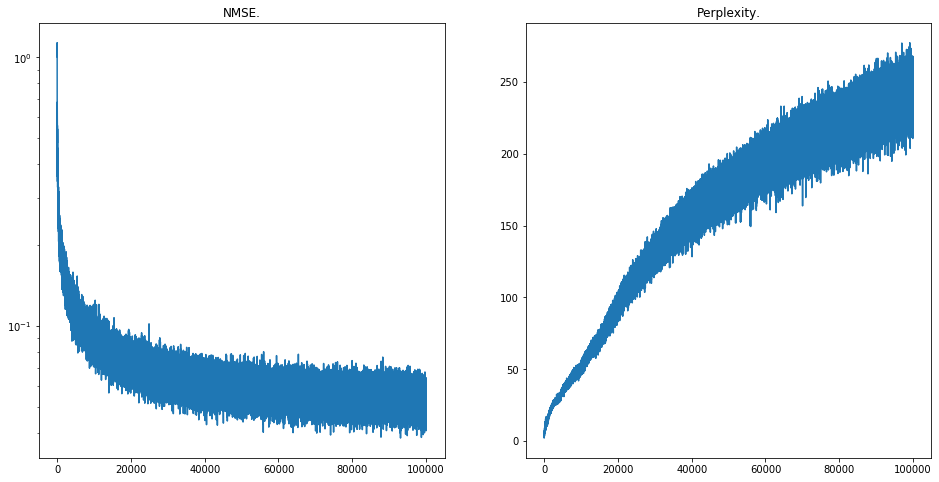

In [0]:
# Plot loss
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.') 

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Perplexity.')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


(-0.5, 255.5, 127.5, -0.5)

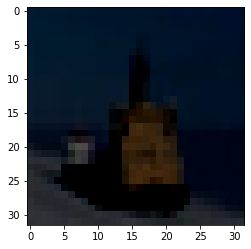

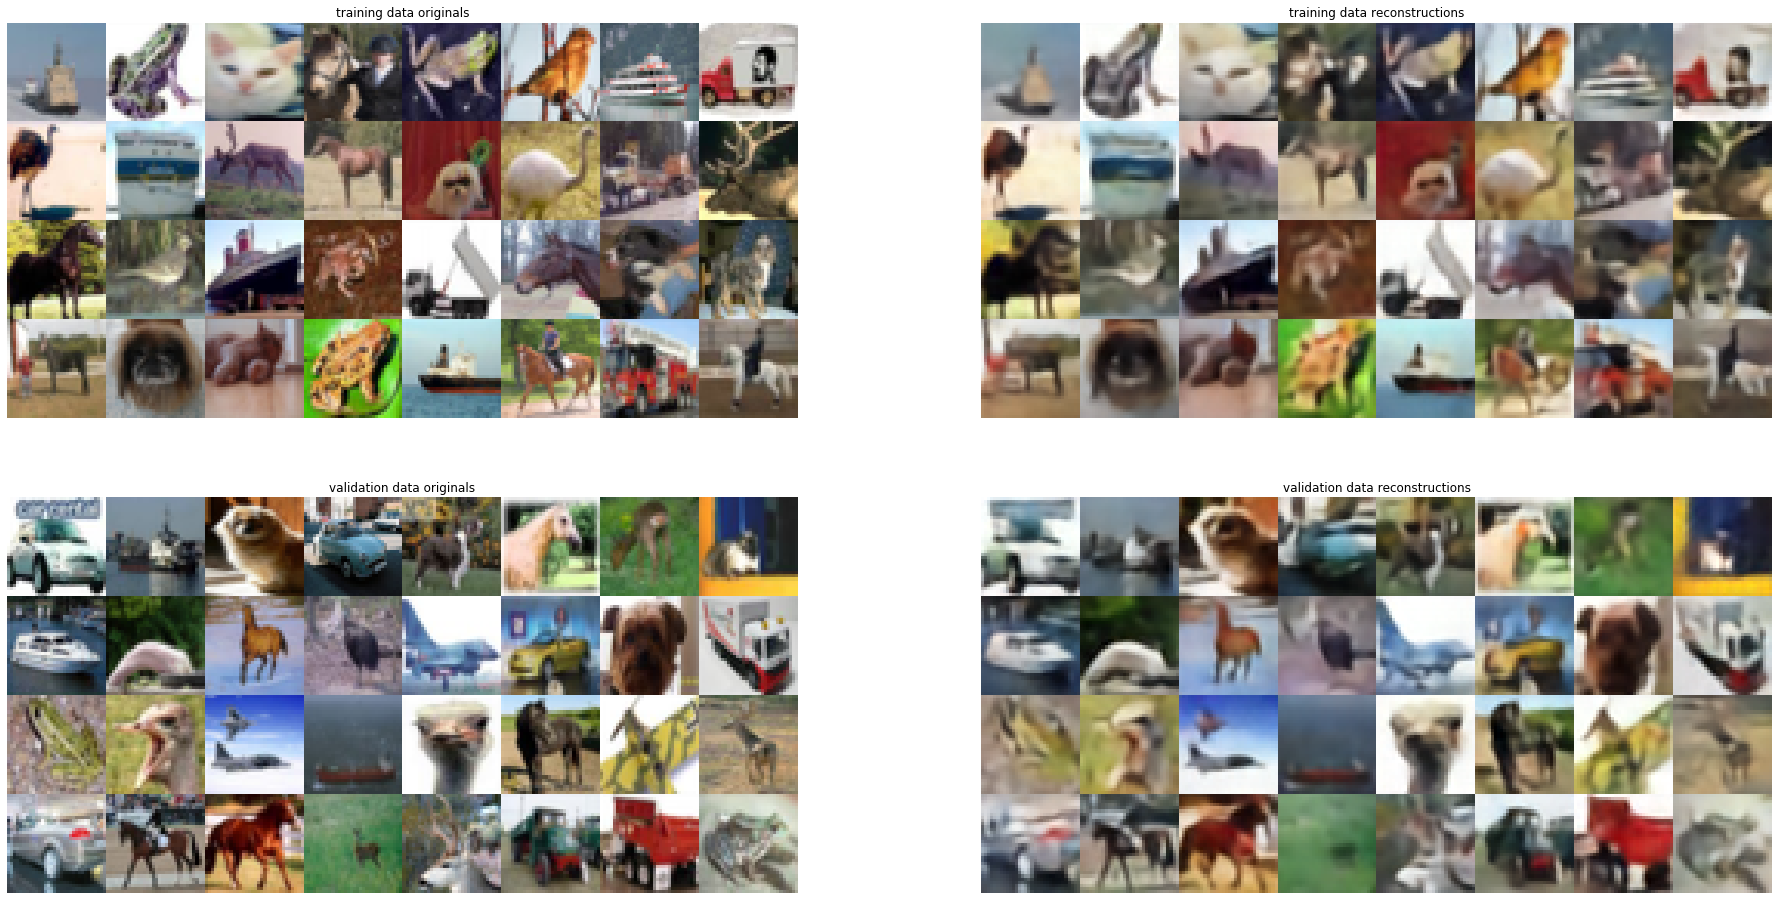

In [0]:
# Reconstructions
sess.run(valid_dataset_iterator.initializer)
train_originals = get_images(sess, subset='train')
train_reconstructions = sess.run(x_recon_eval, feed_dict={x: train_originals})
valid_originals = get_images(sess, subset='valid')
valid_reconstructions = sess.run(x_recon_eval, feed_dict={x: valid_originals})
def convert_batch_to_image_grid(image_batch):
  reshaped = (image_batch.reshape(4, 8, 32, 32, 3)
              .transpose(0, 2, 1, 3, 4)
              .reshape(4 * 32, 8 * 32, 3))
  return reshaped + 0.5

print(train_originals[0].shape)
plt.figure()
plt.imshow(train_originals[0])#cast_and_normalise_images

f = plt.figure(figsize=(32,16))
ax = f.add_subplot(2,2,1)
ax.imshow(convert_batch_to_image_grid(train_originals),
          interpolation='nearest')
ax.set_title('training data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(convert_batch_to_image_grid(train_reconstructions),
          interpolation='nearest')
ax.set_title('training data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(convert_batch_to_image_grid(valid_originals),
          interpolation='nearest')
ax.set_title('validation data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(convert_batch_to_image_grid(valid_reconstructions),
          interpolation='nearest')
ax.set_title('validation data reconstructions')
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[238 270  96 464  96 127 479  96 228 325  60 129 506 194 267 485 190 421
  441 194 442  55 185 320 413 121  63 295 134 193 377  27 449 487 274 199
  333 382 193 346 449 191 377 175 380 241  47  43 325 335 105 432 337 163
  421 288 457  77 339 265  14 479 170 127]]


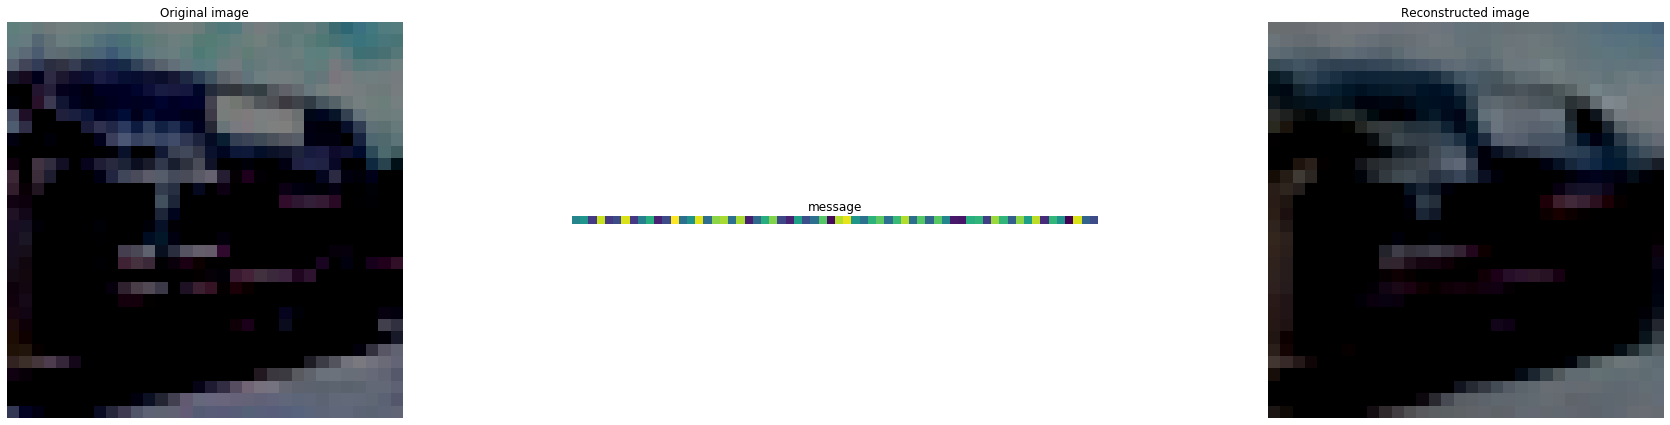

In [0]:
# Language structure experiment
img = get_images(sess, subset='train')[0]
img_batch = np.expand_dims(img, axis=0)

z_samples = sess.run(z_eval, feed_dict={x: img_batch})
z_scalar = np.asarray([np.where(r==1)[0][0] for r in z_samples])
z_scalar = np.expand_dims(z_scalar, 0)
z_img = np.resize(z_scalar,(8,8))


x_recons_exp = sess.run(x_recon_eval, feed_dict={x: img_batch})

print(z_scalar)


f = plt.figure(figsize=(32,16))

ax = f.add_subplot(2,3,1)
ax.imshow(img,
          interpolation='nearest')
ax.set_title('Original image')
ax.axis('off') 

ax = f.add_subplot(2,3,2)
ax.imshow(z_scalar,
          interpolation='nearest')
ax.set_title('message')
ax.axis('off') 

ax = f.add_subplot(2,3,3)
ax.imshow(x_recons_exp.squeeze(0),
          interpolation='nearest')
ax.set_title('Reconstructed image')
ax.axis('off') 

fig = plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 8, 8, 64)
(1, 8, 8)


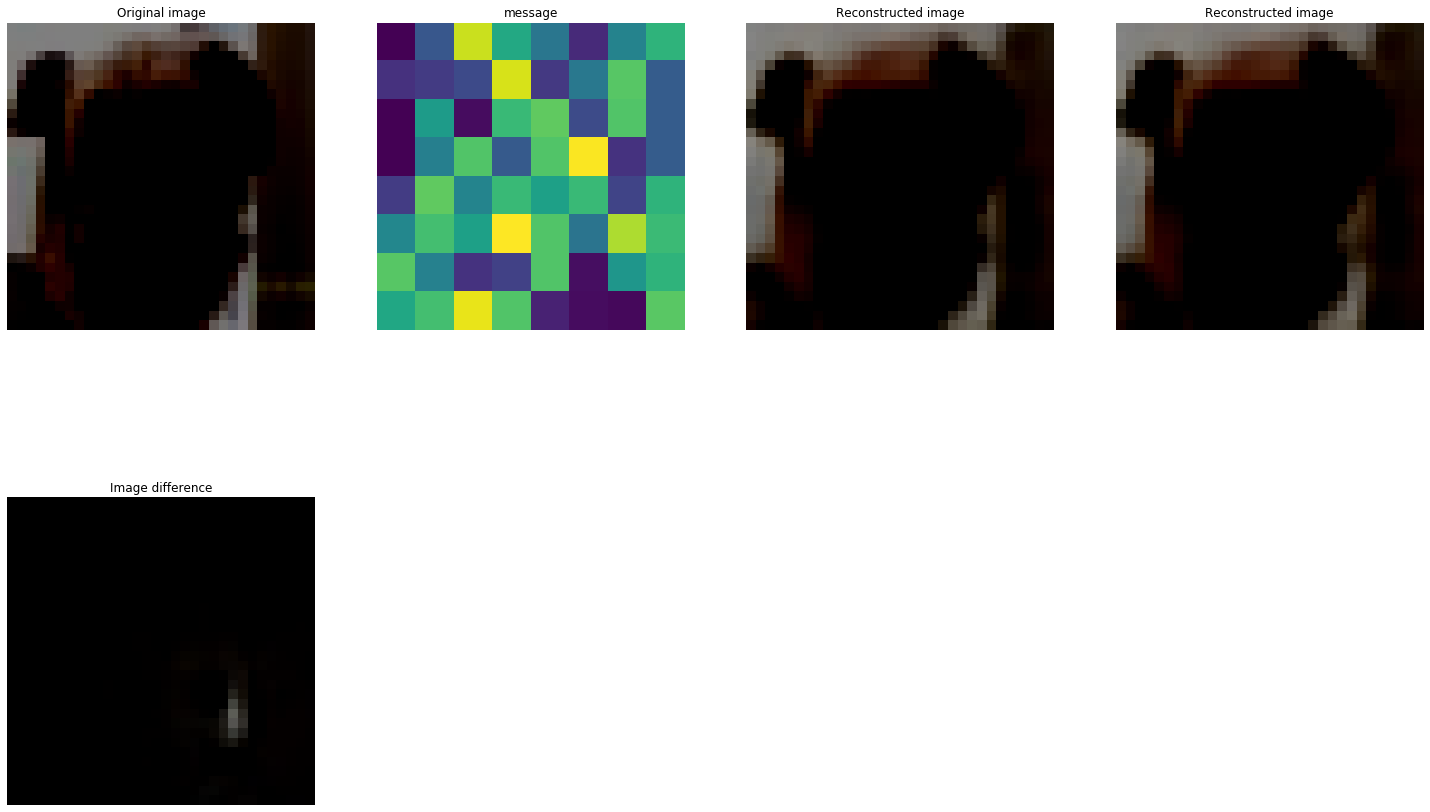

In [0]:
# Language structure experiment
img = get_images(sess, subset='exp')[0]
img_batch = np.expand_dims(img, axis=0)


z_out = sess.run(z, feed_dict={x: img_batch})
print(z_out.shape)

z_ind_sample = sess.run(z_ind, feed_dict={x: img_batch})
print(z_ind_sample.shape)
z_ind_sample[0,5,5] = 200

x_recons_exp = sess.run(x_recon_eval, feed_dict={x: img_batch})
x_recon_ind_exp = sess.run(x_recon_ind, feed_dict={z_in: z_ind_sample})


f = plt.figure(figsize=(32,16))

ax = f.add_subplot(2,5,1)
ax.imshow(img,
          interpolation='nearest')
ax.set_title('Original image')
ax.axis('off') 

ax = f.add_subplot(2,5,2)
ax.imshow(z_ind_sample.squeeze(0),
          interpolation='nearest')
ax.set_title('message')
ax.axis('off') 

ax = f.add_subplot(2,5,3)
ax.imshow(x_recons_exp.squeeze(0),
          interpolation='nearest')
ax.set_title('Reconstructed image')
ax.axis('off') 

ax = f.add_subplot(2,5,4)
ax.imshow(x_recon_ind_exp.squeeze(0),
          interpolation='nearest')
ax.set_title('Reconstructed image')
ax.axis('off') 

ax = f.add_subplot(2,5,6)
ax.imshow(x_recon_ind_exp.squeeze(0)-x_recons_exp.squeeze(0),
          interpolation='nearest')
ax.set_title('Image difference')
ax.axis('off') 

fig = plt.show()